In [1]:
using Flux, Statistics
using Flux: crossentropy, throttle, logitcrossentropy
using Base.Iterators: repeated, partition, flatten
using DelimitedFiles
using LinearAlgebra
using RDatasets
using GLM
using BSON: @save, @load
using Random
using Base.Threads 
using Plots

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/jupyter-nrmeskell/.julia/packages/CUDA/mVgLI/src/initialization.jl:42


In [2]:
function getEdepGateBarA0(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle = lpad(angle,3,"0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67, 2], (8,8))))
end

getEdepGateBarA0 (generic function with 1 method)

In [3]:
#getEdepGateBarA0(1, 0)

In [4]:
function getEdepGateBarA90(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle90 = lpad(angle+90, 3, "0")
    fileName90 = filter(x->occursin(string("A", angle90), x), readdir(folder))[number]
    filePath90 = string(folder, fileName90)
    return return Int.(round.(reshape(readdlm(filePath90)[4:67,2], (8,8))))
end

getEdepGateBarA90 (generic function with 1 method)

In [5]:
#getEdepGateBarA90(1, 40)

In [6]:
function getEdepGateGrid(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    angle = lpad(angle, 3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(readdlm(filePath)[4:515,2]))
end

getEdepGateGrid (generic function with 1 method)

In [7]:
#getEdepGateGrid(1, 45)

dosimeter/gate_data/bars/W05__H05__A000_bars_extracted.txt

In [8]:
function getEdepOhioBarA0(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R...txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA0 (generic function with 1 method)

In [9]:
#getEdepOhioBarA0(1)

In [10]:
function getEdepOhioBarA90(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R.._r.txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA90 (generic function with 1 method)

In [11]:
#getEdepOhioBarA90(1)

In [12]:
function normalize(inputArray)
    min = minimum(inputArray)
    inputArray = (inputArray.-(min))
    max = maximum(inputArray)/1023
    inputArray = (inputArray./max).+1
    return Int.(round.(inputArray))
end

normalize (generic function with 1 method)

In [13]:
#normalize(getEdepOhioBarA90(1))

In [14]:
#normalize(getEdepOhioBarA0(1))

In [15]:
function makeTrainingData()
    numRuns = 15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*numRuns)
    
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i,  (r-1)*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i,  (r-1)*15)
        end
    end
    
    return trainingArray
end

makeTrainingData (generic function with 1 method)

In [16]:
size(filter(x->occursin("E02__W05__H05", x), readdir("/home/jupyter-nrmeskell/dosimeter/gate_data/bars/")))[1]

24

In [17]:
size(filter(x->occursin("A000", x), readdir("/home/jupyter-nrmeskell/dosimeter/gate_data/bars/")))[1]

500

In [18]:
function makeValidationData()
    numRuns = 18-15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i, (r-1)*15 + numRuns*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i, (r-1)*15 + numRuns*15)
        end
    end
    return trainingArray
end

makeValidationData (generic function with 1 method)

In [19]:
getEdepGateBarA0(1, (1-1)*15 + 15*15)

8×8 Matrix{Int64}:
 1  2   5  391  331  27   1   2
 2  3   2  537  408  18   2   1
 0  2  11  430  461   4   1   0
 0  2   4  341  550   3   2   1
 1  1   4  487  360   6   1   0
 3  1   4  433  399   5   3   2
 3  1   3  365  363   2   5   0
 0  1  48  162  188  25  17  28

In [20]:
function makeTargetData()
    numRuns = 15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15)
        end
    end
    return trainingArray
end

makeTargetData (generic function with 1 method)

In [21]:
#makeTargetData()

In [22]:
function makeValTargetData()
    numRuns = 18-15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15 + 225)
        end
    end
    return trainingArray
end

makeValTargetData (generic function with 1 method)

In [23]:
#makeValTargetData()

In [24]:
function makeInputData()
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    trainingSize = size(filter(x->occursin("_r.txt", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize)
    
    for i = 1:trainingSize
        trainingArray[:,:,1,i] = getEdepOhioBarA0(i)
        trainingArray[:,:,2,i] = getEdepOhioBarA90(i)
    end
    return trainingArray
end

makeInputData (generic function with 1 method)

In [25]:
#makeInputData()

In [26]:
trainingArray = Float32.(makeTrainingData())

8×8×2×7500 Array{Float32, 4}:
[:, :, 1, 1] =
 2.0  3.0   2.0  379.0  382.0   3.0  0.0  0.0
 0.0  2.0   2.0  304.0  404.0   2.0  2.0  0.0
 2.0  2.0   5.0  320.0  341.0   2.0  0.0  0.0
 2.0  1.0  23.0  399.0  375.0   3.0  4.0  0.0
 1.0  3.0   6.0  369.0  484.0   7.0  1.0  0.0
 0.0  2.0   2.0  374.0  469.0   4.0  1.0  2.0
 1.0  1.0   3.0  253.0  421.0   4.0  1.0  2.0
 1.0  0.0  29.0  156.0  193.0  20.0  3.0  1.0

[:, :, 2, 1] =
 1.0   3.0  20.0  462.0  306.0   2.0  1.0  1.0
 0.0   5.0  21.0  517.0  295.0   2.0  1.0  1.0
 0.0   1.0   2.0  557.0  406.0   2.0  1.0  0.0
 1.0   0.0   5.0  497.0  517.0   2.0  4.0  1.0
 0.0   0.0  11.0  421.0  390.0   4.0  2.0  2.0
 1.0   2.0  35.0  334.0  254.0   2.0  3.0  0.0
 1.0   0.0  27.0  339.0  417.0  11.0  0.0  1.0
 1.0  31.0   1.0  218.0  239.0  20.0  0.0  1.0

[:, :, 1, 2] =
  0.0  4.0  13.0  300.0  300.0   6.0  2.0  2.0
  1.0  1.0   4.0  429.0  344.0   5.0  1.0  0.0
  2.0  3.0   3.0  398.0  331.0  20.0  4.0  2.0
  2.0  2.0  35.0  536.0  321.0   2.0  

In [27]:
targetArray = Float32.(makeTargetData())

512×7500 Matrix{Float32}:
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  …  0.0  0.0   0.0  0.0  0.0  2.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  17.0  0.0  0.0  0.0  4.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  0.0     1.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  2.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  22.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  1.0  19.0  2.0  0.0  2.0  5.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  1.0  19.0  0.0  1.0  3.0  5.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0     1.0  0.0   0.0  0.0  0.0  2.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  18.0  0.0  0.0  1.0  1.0
 ⋮          

In [28]:
validationArray = Float32.(makeValidationData())

8×8×2×1500 Array{Float32, 4}:
[:, :, 1, 1] =
 1.0   1.0   3.0  308.0  400.0   3.0   2.0  3.0
 0.0   0.0   3.0  352.0  378.0   5.0   1.0  0.0
 1.0   2.0   2.0  341.0  432.0  13.0   1.0  2.0
 0.0   1.0   3.0  442.0  370.0   3.0   3.0  2.0
 2.0   2.0  42.0  418.0  363.0   5.0   3.0  0.0
 1.0   2.0   3.0  284.0  321.0  10.0   1.0  0.0
 1.0   1.0   2.0  237.0  296.0  18.0   2.0  2.0
 1.0  24.0  13.0  140.0  170.0   3.0  21.0  1.0

[:, :, 2, 1] =
  1.0  1.0   4.0  365.0  331.0   4.0   2.0   1.0
  3.0  2.0  14.0  413.0  280.0   5.0   2.0   1.0
  1.0  3.0   5.0  466.0  334.0   3.0   2.0   3.0
  1.0  2.0   4.0  393.0  411.0   4.0   1.0   0.0
  3.0  2.0   1.0  231.0  446.0  51.0   1.0   0.0
  1.0  1.0   4.0  384.0  456.0  55.0   2.0   0.0
  1.0  1.0   3.0  351.0  392.0   2.0   1.0   0.0
 15.0  1.0   1.0  177.0  184.0   4.0  24.0  14.0

[:, :, 1, 2] =
 0.0  1.0  14.0  342.0  359.0   3.0  0.0  1.0
 3.0  2.0   4.0  328.0  363.0   3.0  1.0  1.0
 1.0  2.0   1.0  250.0  359.0   6.0  3.0  2.0
 0.0  3.0

In [29]:
validationTargetArray = Float32.(makeValTargetData())

512×1500 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  3.0  0.0  0.0   0.0  0.0  0.0  20.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0   1.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0     5.0  0.0  3.0   0.0  0.0  0.0  10.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  3.0   0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  13.0  0.0  0.0   0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  32.0  0.0  0.0   9.0

In [30]:
inputArray = Float32.(makeInputData())

8×8×2×21 Array{Float32, 4}:
[:, :, 1, 1] =
 38484.0  42128.0  52850.0  126117.0  208366.0  54216.0  42413.0  38391.0
 39382.0  44555.0  47446.0  118228.0  285328.0  61556.0  41870.0  39128.0
 36595.0  39956.0  55851.0  189571.0  294911.0  57231.0  42411.0  38908.0
 38021.0  43502.0  45917.0  122588.0  483994.0  71271.0  40778.0  39157.0
 40115.0  46611.0  55757.0  176140.0  345909.0  74524.0  42913.0  39929.0
 39228.0  38664.0  58439.0  162217.0  244550.0  68536.0  43572.0  39139.0
 37466.0  37933.0  56898.0  131986.0  361086.0  60613.0  48624.0  37953.0
 35604.0  38155.0  43116.0   84692.0  184161.0  70698.0  43053.0  37902.0

[:, :, 2, 1] =
 19404.0  22059.0  44432.0  101296.0   77978.0  36257.0  21430.0  19332.0
 20006.0  24228.0  42568.0   87020.0  105097.0  53825.0  21343.0  20054.0
 17905.0  20826.0  56275.0  160868.0  105372.0  47073.0  21694.0  19664.0
 19379.0  23974.0  36643.0   91733.0  144345.0  65212.0  20635.0  20134.0
 20977.0  26756.0  56546.0  140444.0  126791.0  68834

In [31]:
function plotResults(m)
    image = rand((1: size(trainingArray)[2]))
    print(image)
    display(heatmap(reshape(Int64.(round.(m(validationArray)))[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Prediction"))
    display(heatmap(reshape(validationTargetArray[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Target"))
    display(heatmap(reshape(Int64.(round.(m(inputArray)))[:,1], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="Ohio Data Prediction"))
end

plotResults (generic function with 1 method)

In [32]:
m = Chain(Conv((2,2), 2=>8, pad=(1,1), relu),
        Conv((2,2), 8=>16, pad=(1,1), relu),
        Dropout(0.05),

        x -> reshape(x, :, size(x,4)), 

        Dense(1600, 900),
        Dense(900, 8*8*8),
        x -> abs.(x))

Chain(Conv((2, 2), 2=>8, relu), Conv((2, 2), 8=>16, relu), Dropout(0.05), #25, Dense(1600, 900), Dense(900, 512), #26)

In [33]:
loss(x, y) = mean((m(x)-y).^2)
opt = ADAM(0.01)
dataset = (repeated((trainingArray, targetArray), 50))
evalcb = () -> @show (loss(trainingArray, targetArray)) 

CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
print("Training R2: ", CurrentR2, '\n')
CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
print("Validation R2: ", CurrentVR2, '\n')

CVR2 = 0.0
i = 1

Training R2: 0.00014489255259009237
Validation R2: 0.00013204642856701199


1

loss(trainingArray, targetArray) = 608377.6f0
loss(trainingArray, targetArray) = 104687.195f0
loss(trainingArray, targetArray) = 37877.316f0
loss(trainingArray, targetArray) = 16184.894f0
loss(trainingArray, targetArray) = 7787.0654f0
loss(trainingArray, targetArray) = 6350.5444f0
loss(trainingArray, targetArray) = 5681.143f0
loss(trainingArray, targetArray) = 5169.6714f0
loss(trainingArray, targetArray) = 4606.666f0
loss(trainingArray, targetArray) = 3992.9592f0
Training R2: 0.6477820645979729
Validation R2: 0.67632812650095

	

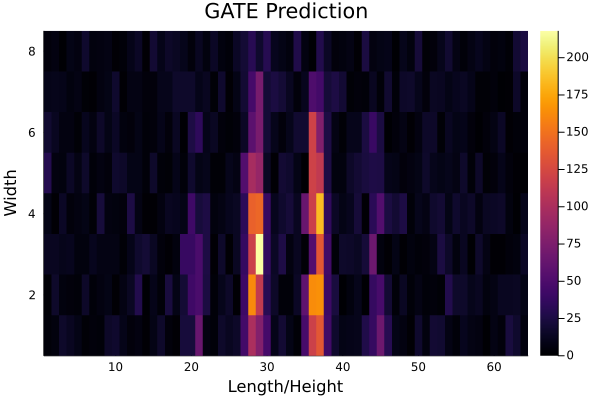

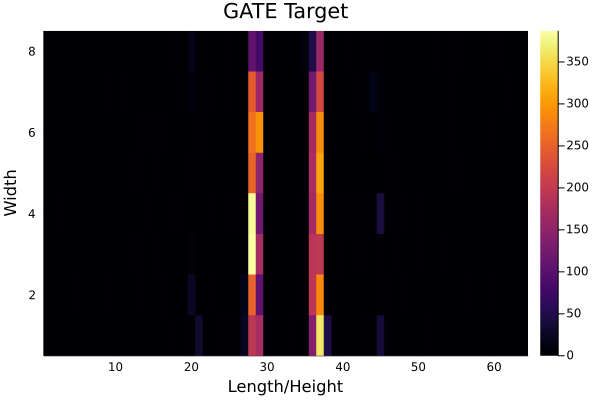

4

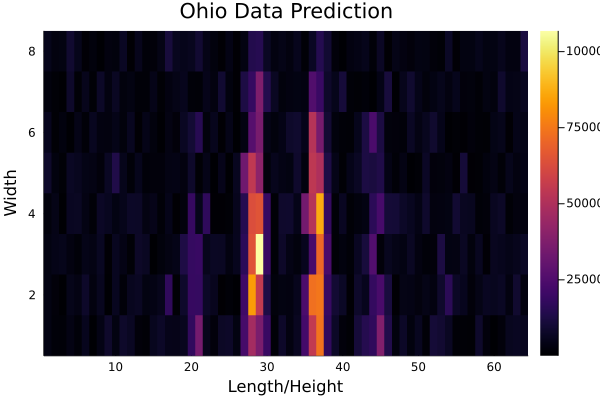

loss(trainingArray, targetArray) = 3668.172f0
loss(trainingArray, targetArray) = 3244.8303f0
loss(trainingArray, targetArray) = 2931.6614f0
loss(trainingArray, targetArray) = 2633.5051f0
loss(trainingArray, targetArray) = 2446.6848f0
loss(trainingArray, targetArray) = 2337.5864f0
loss(trainingArray, targetArray) = 2238.9492f0
loss(trainingArray, targetArray) = 2160.3838f0
loss(trainingArray, targetArray) = 2114.0474f0
loss(trainingArray, targetArray) = 2083.4026f0


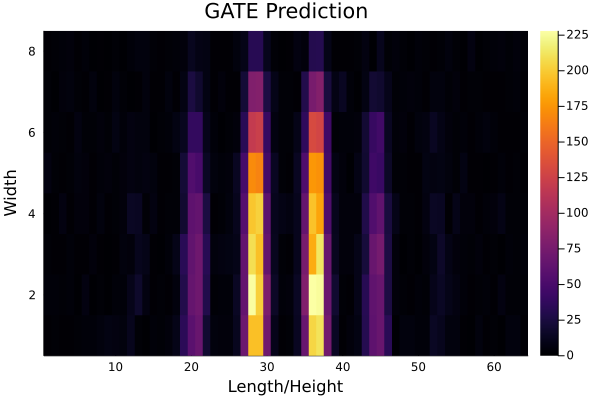

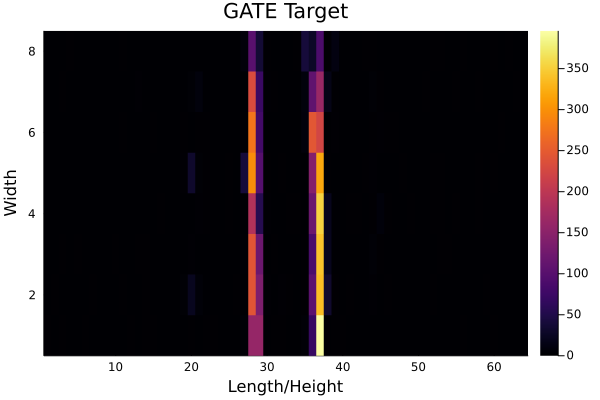

Training R2: 0.7168759876215384
Validation R2: 0.7523643477234643

	7

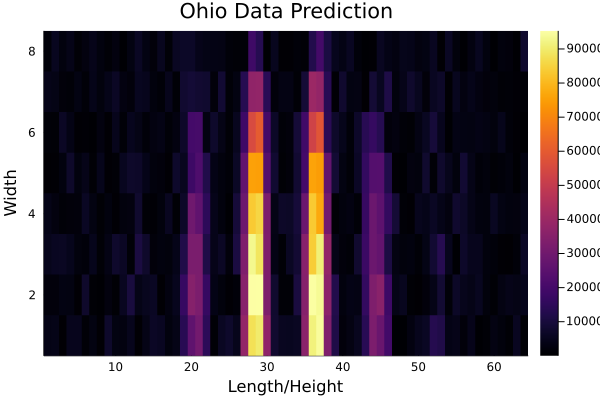

loss(trainingArray, targetArray) = 2051.828f0
loss(trainingArray, targetArray) = 2025.7355f0
loss(trainingArray, targetArray) = 2002.8335f0
loss(trainingArray, targetArray) = 1978.343f0
loss(trainingArray, targetArray) = 1959.4451f0
loss(trainingArray, targetArray) = 1941.2659f0
loss(trainingArray, targetArray) = 1923.3385f0
loss(trainingArray, targetArray) = 1901.906f0
loss(trainingArray, targetArray) = 1884.0254f0
loss(trainingArray, targetArray) = 1862.4175f0
Training R2: 0.7335142143225051


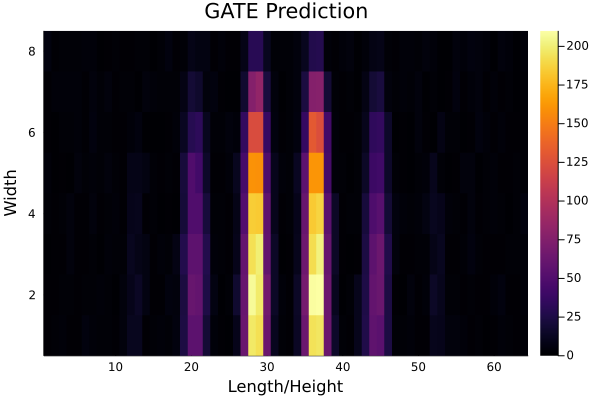

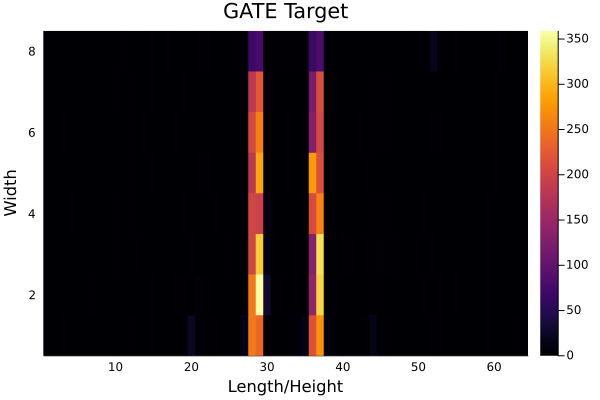

Validation R2: 0.7712040090121373

	3

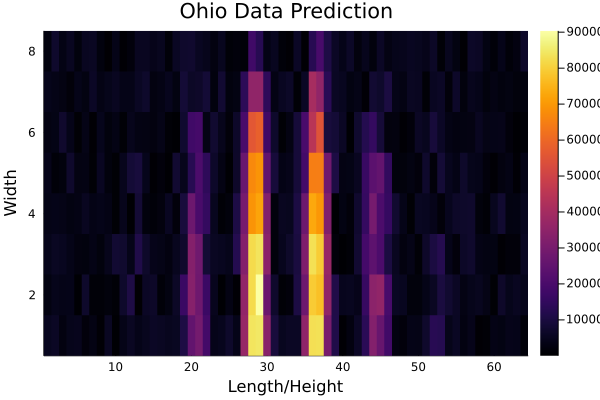

loss(trainingArray, targetArray) = 1855.1776f0
loss(trainingArray, targetArray) = 1833.3542f0
loss(trainingArray, targetArray) = 1815.0299f0
loss(trainingArray, targetArray) = 1796.5953f0
loss(trainingArray, targetArray) = 1778.1018f0
loss(trainingArray, targetArray) = 1755.8925f0
loss(trainingArray, targetArray) = 1737.3528f0
loss(trainingArray, targetArray) = 1715.1002f0
loss(trainingArray, targetArray) = 1696.6648f0
loss(trainingArray, targetArray) = 1678.3691f0


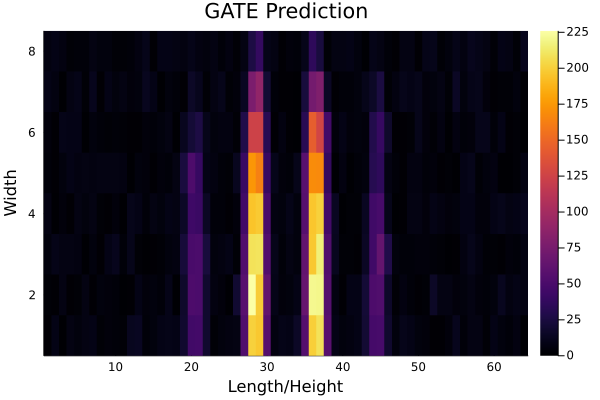

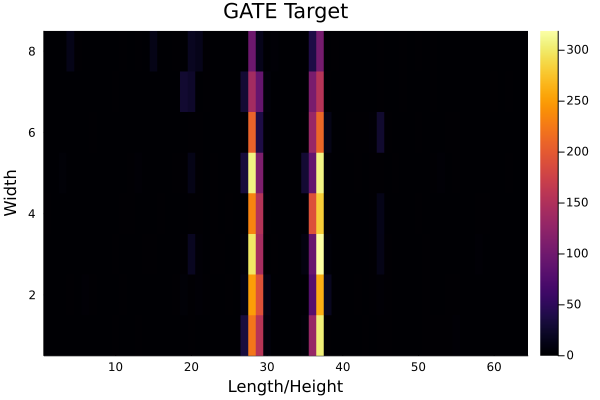

Training R2: 0.7569139458777445
Validation R2: 0.7979503806605217

	8

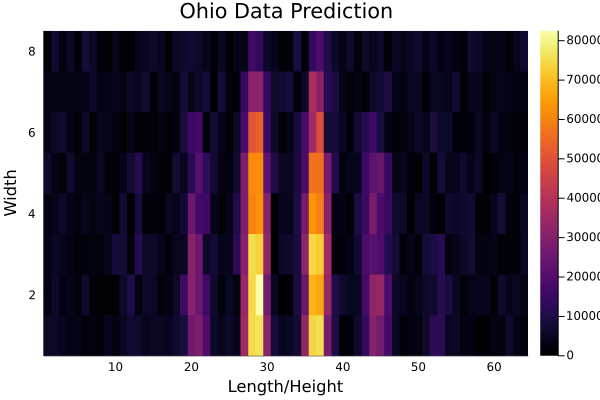

loss(trainingArray, targetArray) = 1671.0839f0
loss(trainingArray, targetArray) = 1652.9883f0
loss(trainingArray, targetArray) = 1635.0321f0
loss(trainingArray, targetArray) = 1617.2438f0
loss(trainingArray, targetArray) = 1599.6804f0
loss(trainingArray, targetArray) = 1582.3127f0
loss(trainingArray, targetArray) = 1565.1309f0
loss(trainingArray, targetArray) = 1544.7803f0
loss(trainingArray, targetArray) = 1524.7821f0
loss(trainingArray, targetArray) = 1505.2625f0


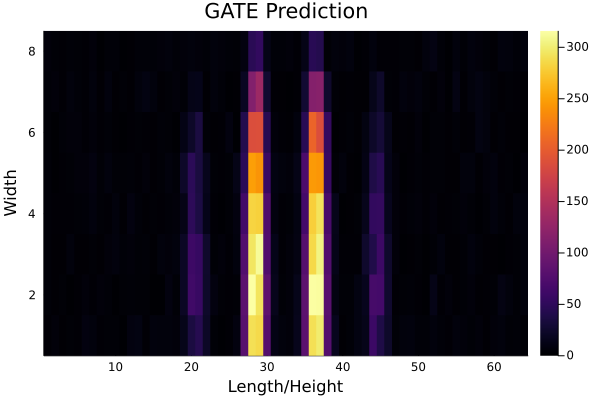

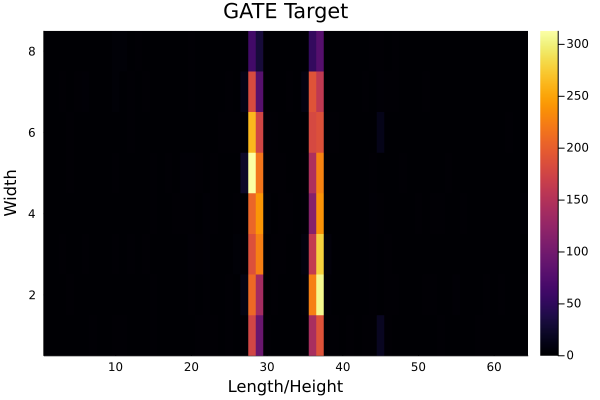

Training R2: 0.7846870170617541
Validation R2: 0.829106670419509

	6

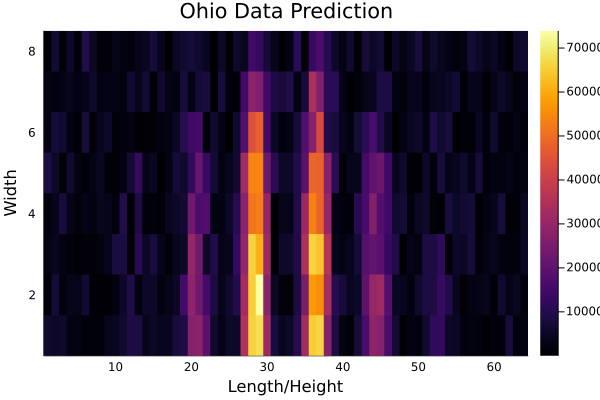

loss(trainingArray, targetArray) = 1498.8658f0
loss(trainingArray, targetArray) = 1483.1736f0
loss(trainingArray, targetArray) = 1464.8655f0
loss(trainingArray, targetArray) = 1447.093f0
loss(trainingArray, targetArray) = 1429.7877f0
loss(trainingArray, targetArray) = 1412.9565f0
loss(trainingArray, targetArray) = 1396.6072f0
loss(trainingArray, targetArray) = 1380.7341f0
loss(trainingArray, targetArray) = 1365.3699f0


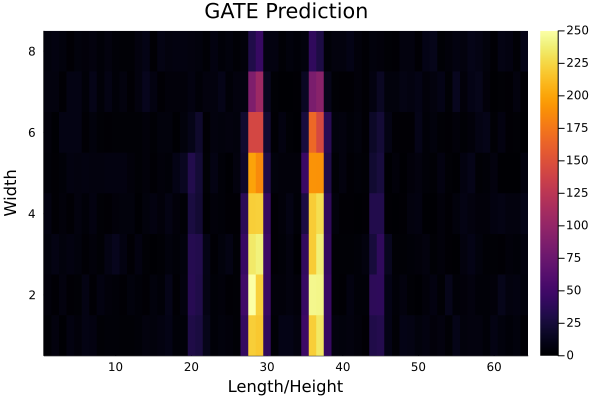

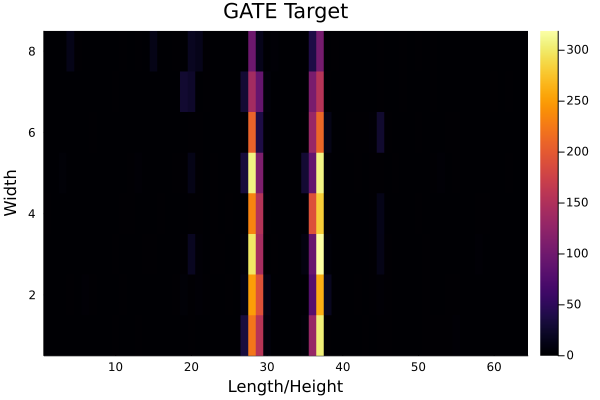

Training R2: 0.8108044871155247
Validation R2: 0.8573578299263961

	8

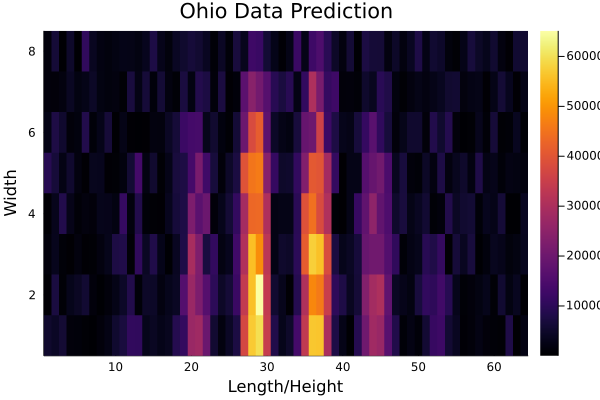

loss(trainingArray, targetArray) = 1357.8859f0
loss(trainingArray, targetArray) = 1343.2849f0
loss(trainingArray, targetArray) = 1331.4915f0
loss(trainingArray, targetArray) = 1317.8407f0
loss(trainingArray, targetArray) = 1304.8025f0
loss(trainingArray, targetArray) = 1292.362f0
loss(trainingArray, targetArray) = 1280.4812f0
loss(trainingArray, targetArray) = 1269.2206f0
loss(trainingArray, targetArray) = 1260.2747f0


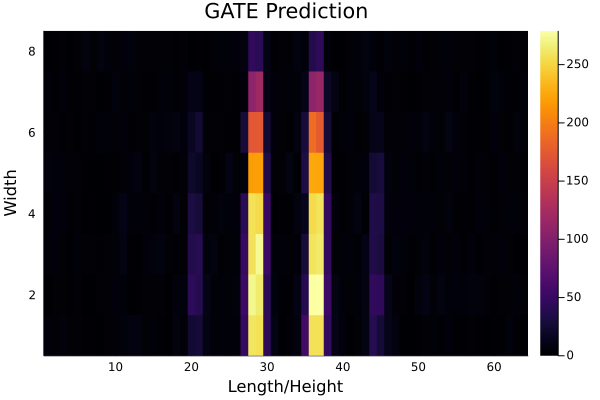

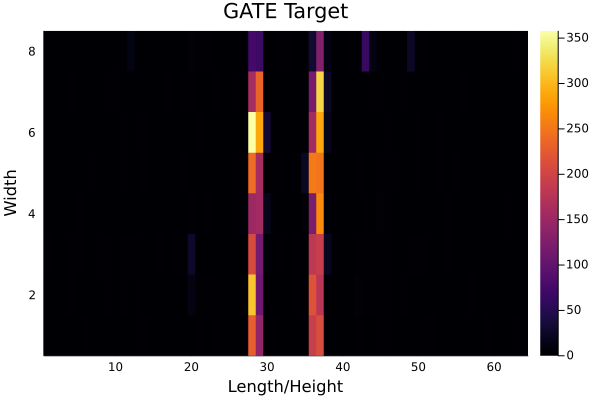

Training R2: 0.8315090227454909
Validation R2: 0.8788338550860131

	5

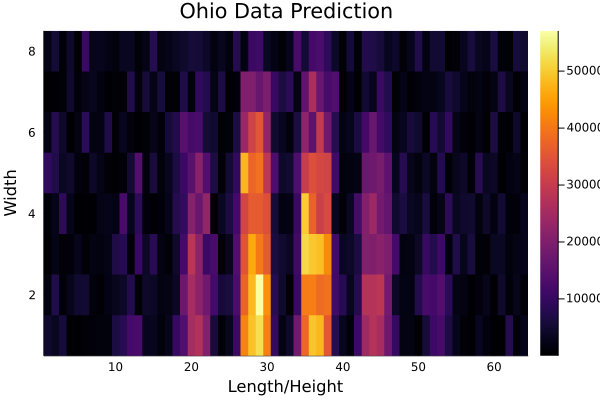

loss(trainingArray, targetArray) = 1253.431f0
loss(trainingArray, targetArray) = 1243.7222f0
loss(trainingArray, targetArray) = 1236.0779f0
loss(trainingArray, targetArray) = 1227.4211f0
loss(trainingArray, targetArray) = 1220.6422f0
loss(trainingArray, targetArray) = 1213.0135f0
loss(trainingArray, targetArray) = 1205.9451f0
loss(trainingArray, targetArray) = 1199.402f0
loss(trainingArray, targetArray) = 1193.3875f0


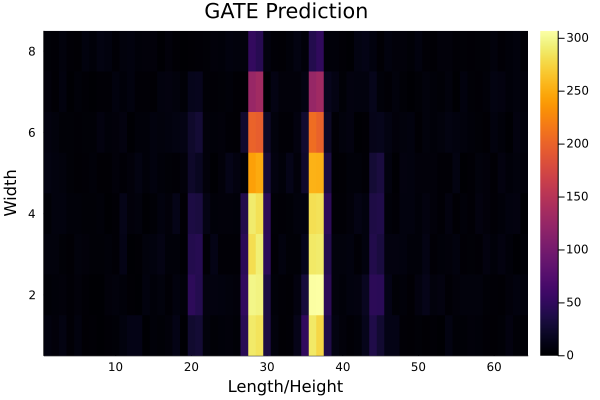

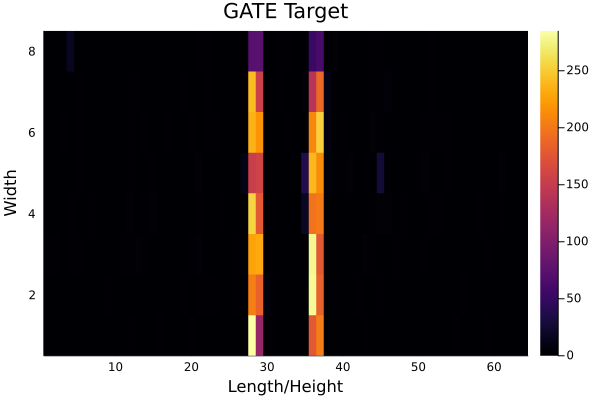

Training R2: 0.8453492735114699
Validation R2: 0.8924943291495797

	1

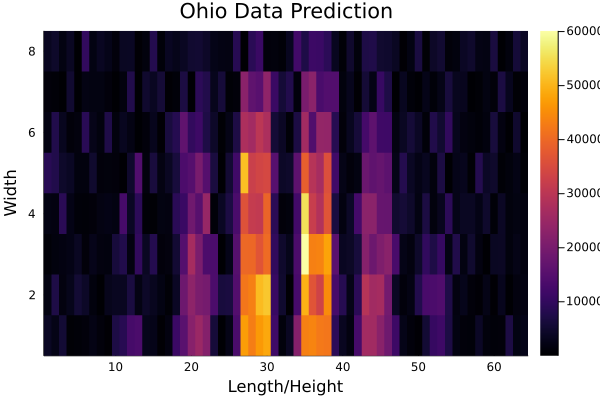

loss(trainingArray, targetArray) = 1189.6125f0
loss(trainingArray, targetArray) = 1184.2717f0
loss(trainingArray, targetArray) = 1179.3607f0
loss(trainingArray, targetArray) = 1174.8392f0
loss(trainingArray, targetArray) = 1170.6284f0
loss(trainingArray, targetArray) = 1166.6927f0
loss(trainingArray, targetArray) = 1163.1044f0
loss(trainingArray, targetArray) = 1159.8062f0
loss(trainingArray, targetArray) = 1157.2141f0


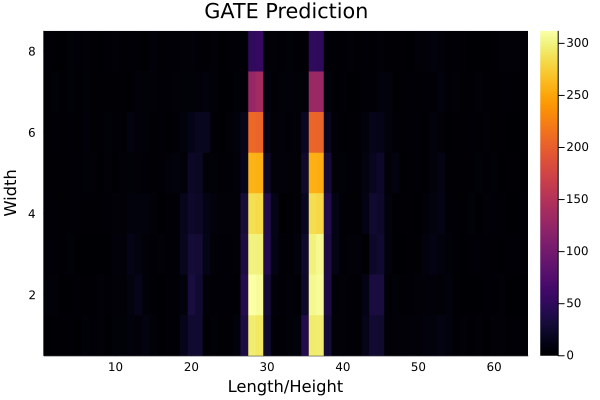

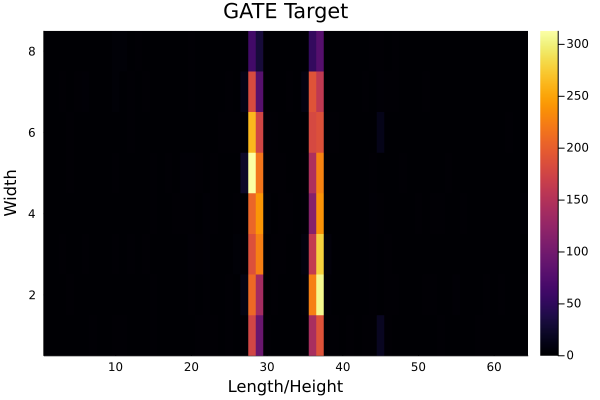

Training R2: 0.8536318779407461
Validation R2: 0.9003083982744918

	6

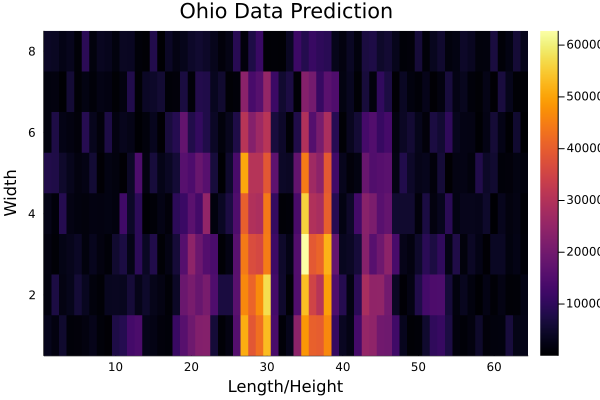

loss(trainingArray, targetArray) = 1155.7222f0
loss(trainingArray, targetArray) = 1153.3715f0
loss(trainingArray, targetArray) = 1151.1823f0
loss(trainingArray, targetArray) = 1149.146f0
loss(trainingArray, targetArray) = 1147.154f0
loss(trainingArray, targetArray) = 1144.9061f0
loss(trainingArray, targetArray) = 1142.7792f0
loss(trainingArray, targetArray) = 1140.7708f0
loss(trainingArray, targetArray) = 1139.2195f0
loss(trainingArray, targetArray) = 1137.7042f0


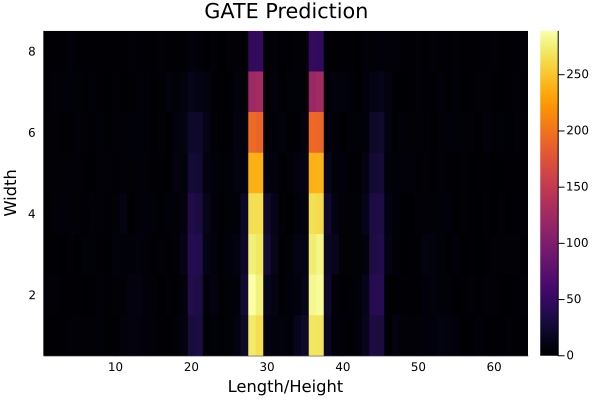

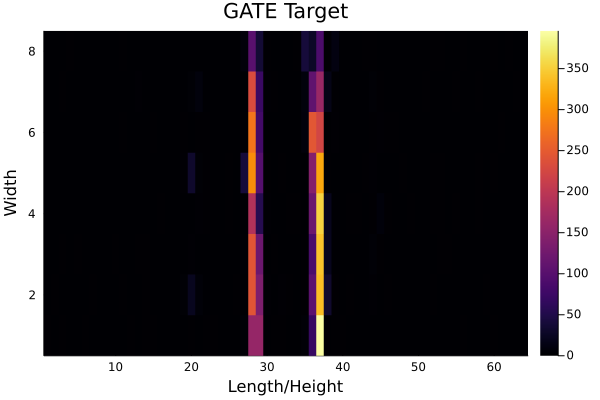

Training R2: 0.8589822200130117
Validation R2: 0.9051772646142096

	7

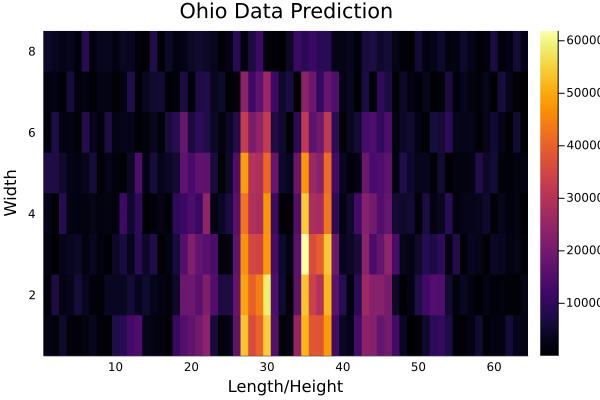

loss(trainingArray, targetArray) = 1137.1199f0
loss(trainingArray, targetArray) = 1135.7008f0
loss(trainingArray, targetArray) = 1134.0994f0
loss(trainingArray, targetArray) = 1132.7853f0
loss(trainingArray, targetArray) = 1131.4968f0
loss(trainingArray, targetArray) = 1130.2485f0
loss(trainingArray, targetArray) = 1129.0731f0
loss(trainingArray, targetArray) = 1127.7229f0
loss(trainingArray, targetArray) = 1126.6061f0
loss(trainingArray, targetArray) = 1125.4534f0


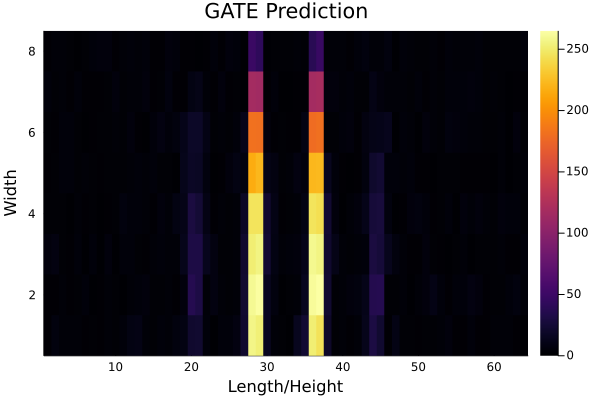

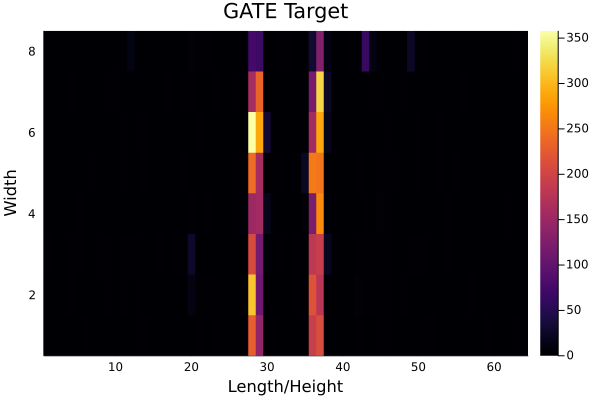

Training R2: 0.8627911810921423
Validation R2: 0.9086626079806702

	5

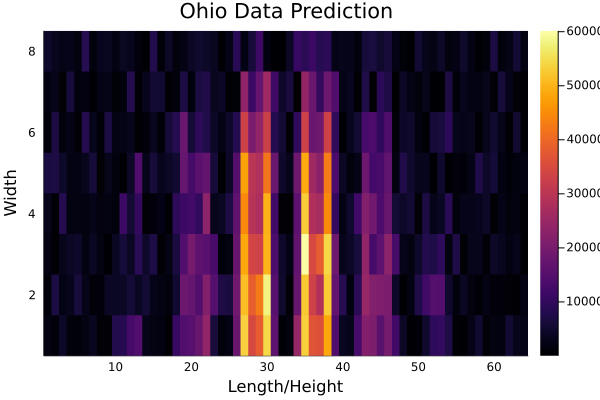

loss(trainingArray, targetArray) = 1124.7694f0
loss(trainingArray, targetArray) = 1123.5199f0
loss(trainingArray, targetArray) = 1122.321f0
loss(trainingArray, targetArray) = 1121.152f0
loss(trainingArray, targetArray) = 1119.9194f0
loss(trainingArray, targetArray) = 1118.9333f0
loss(trainingArray, targetArray) = 1117.9794f0
loss(trainingArray, targetArray) = 1116.8745f0
loss(trainingArray, targetArray) = 1115.9888f0


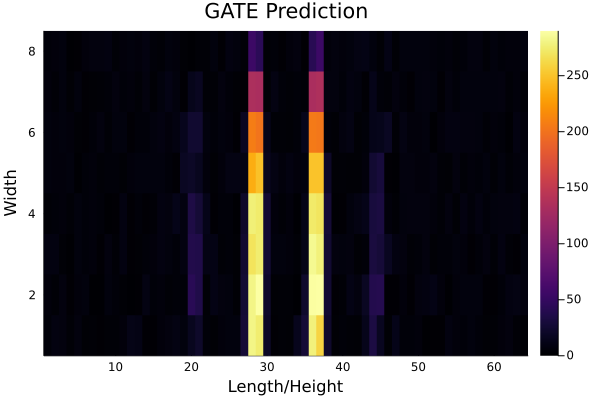

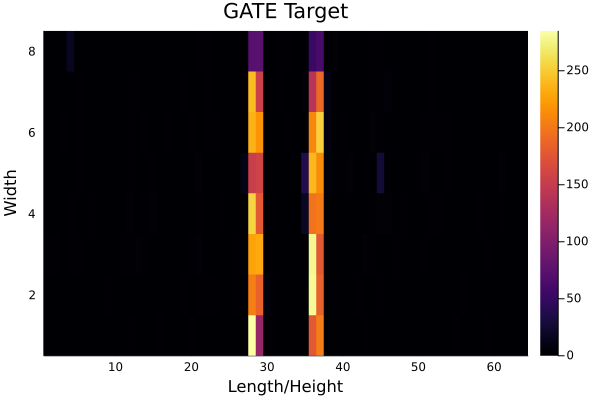

Training R2: 0.8659665289336778
Validation R2: 0.9114974588539007

	1

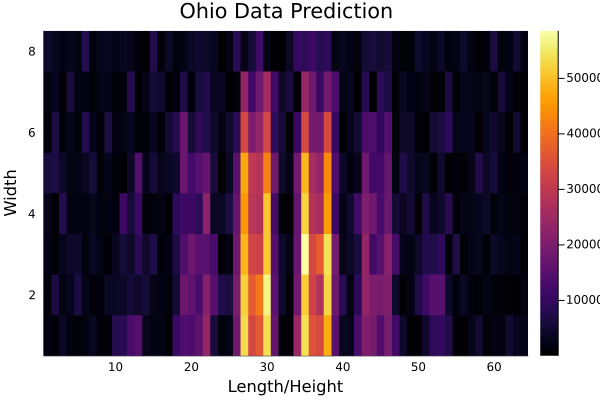

loss(trainingArray, targetArray) = 1115.0848f0
loss(trainingArray, targetArray) = 1114.1974f0
loss(trainingArray, targetArray) = 1113.0424f0
loss(trainingArray, targetArray) = 1112.1362f0
loss(trainingArray, targetArray) = 1111.2811f0
loss(trainingArray, targetArray) = 1110.4478f0
loss(trainingArray, targetArray) = 1109.5858f0
loss(trainingArray, targetArray) = 1108.6068f0
loss(trainingArray, targetArray) = 1107.5905f0
loss(trainingArray, targetArray) = 1106.7362f0
Training R2: 0.8690621777774159


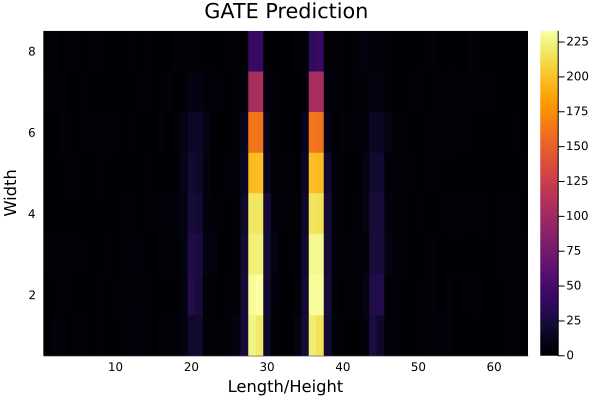

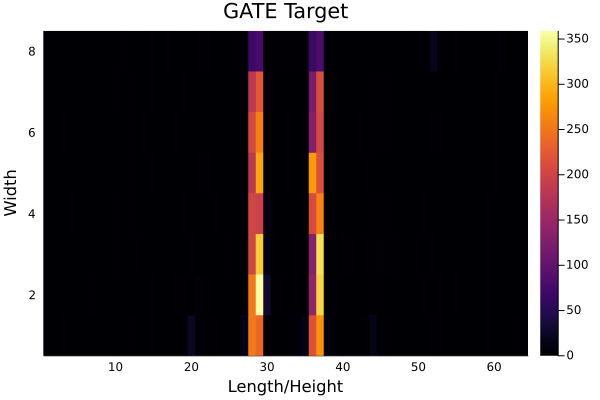

Validation R2: 0.914063281607568

	3

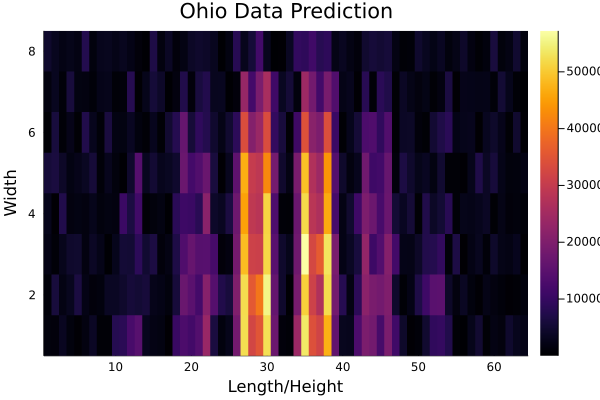

loss(trainingArray, targetArray) = 1106.3788f0
loss(trainingArray, targetArray) = 1105.3766f0
loss(trainingArray, targetArray) = 1104.5302f0
loss(trainingArray, targetArray) = 1103.5364f0
loss(trainingArray, targetArray) = 1102.5365f0
loss(trainingArray, targetArray) = 1101.7161f0
loss(trainingArray, targetArray) = 1100.7599f0
loss(trainingArray, targetArray) = 1099.8f0
loss(trainingArray, targetArray) = 1099.0045f0


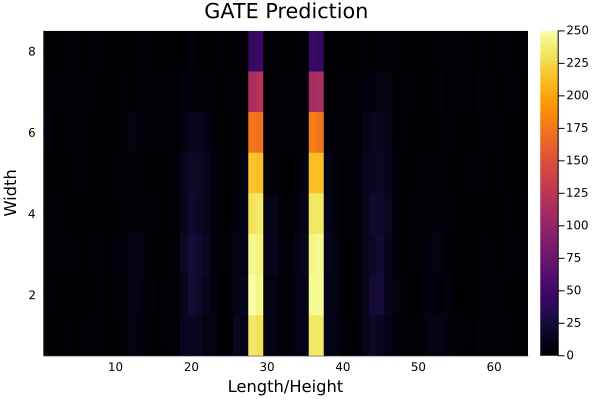

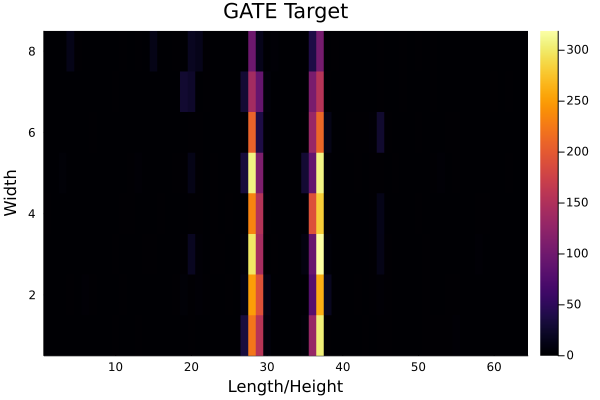

Training R2: 0.8723853839115805
Validation R2: 0.9166173744859526

	8

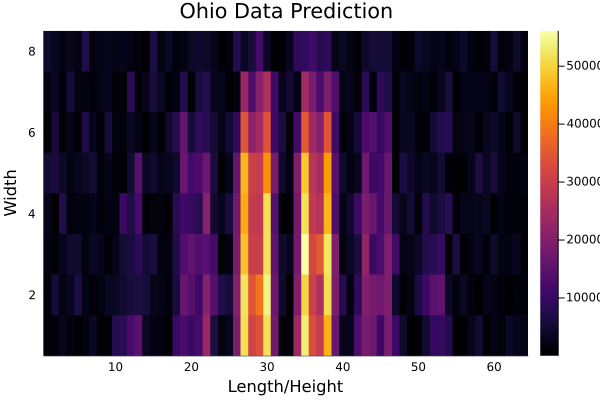

loss(trainingArray, targetArray) = 1098.1787f0
loss(trainingArray, targetArray) = 1097.3795f0
loss(trainingArray, targetArray) = 1096.4076f0
loss(trainingArray, targetArray) = 1095.439f0
loss(trainingArray, targetArray) = 1094.6556f0
loss(trainingArray, targetArray) = 1093.8822f0
loss(trainingArray, targetArray) = 1093.097f0
loss(trainingArray, targetArray) = 1092.2843f0
loss(trainingArray, targetArray) = 1091.3695f0
loss(trainingArray, targetArray) = 1090.5721f0


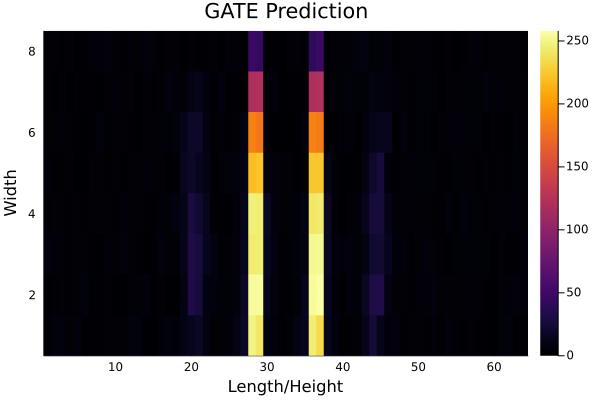

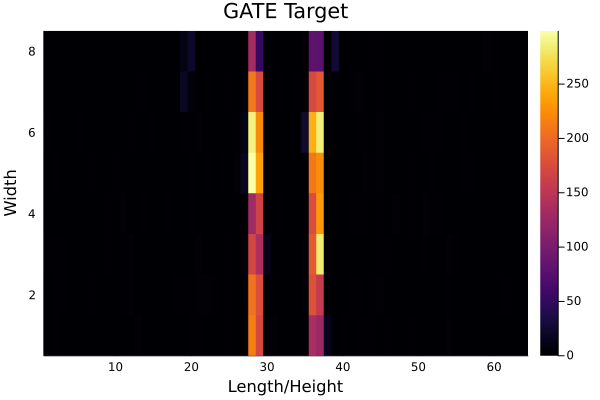

Training R2: 0.8758981151151755
Validation R2: 0.9191474150496155

	2

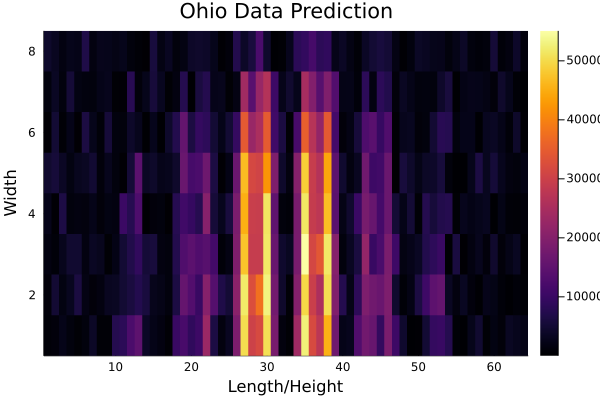

loss(trainingArray, targetArray) = 1090.2509f0
loss(trainingArray, targetArray) = 1089.3254f0
loss(trainingArray, targetArray) = 1088.4222f0
loss(trainingArray, targetArray) = 1087.4924f0
loss(trainingArray, targetArray) = 1086.7346f0
loss(trainingArray, targetArray) = 1085.7302f0
loss(trainingArray, targetArray) = 1084.7646f0
loss(trainingArray, targetArray) = 1083.8297f0
loss(trainingArray, targetArray) = 1082.9246f0


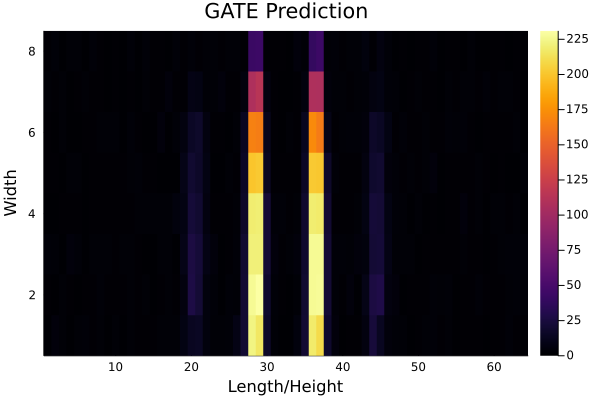

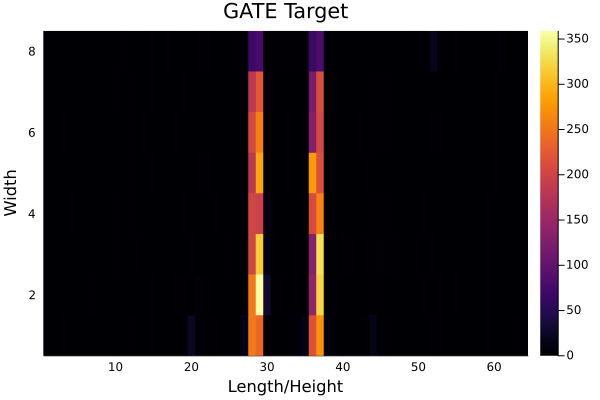

Training R2: 0.8797770521935644
Validation R2: 0.9217073736990958

	3

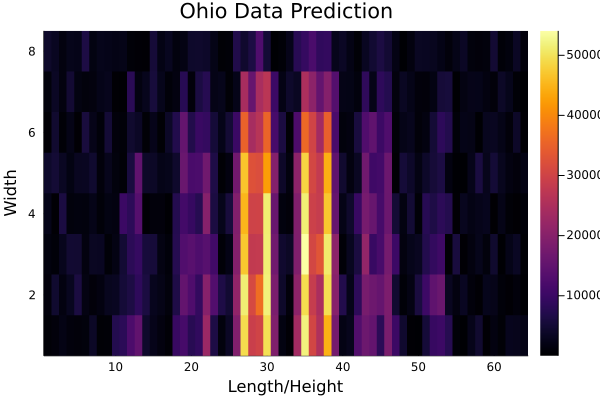

loss(trainingArray, targetArray) = 1082.4916f0
loss(trainingArray, targetArray) = 1081.572f0
loss(trainingArray, targetArray) = 1080.7548f0
loss(trainingArray, targetArray) = 1079.8201f0
loss(trainingArray, targetArray) = 1078.9137f0
loss(trainingArray, targetArray) = 1078.0167f0
loss(trainingArray, targetArray) = 1077.1245f0
loss(trainingArray, targetArray) = 1076.3169f0
loss(trainingArray, targetArray) = 1075.4055f0
Training R2: 0.8840933658979374


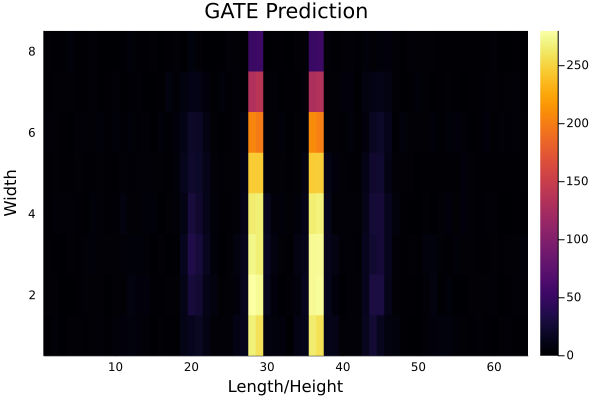

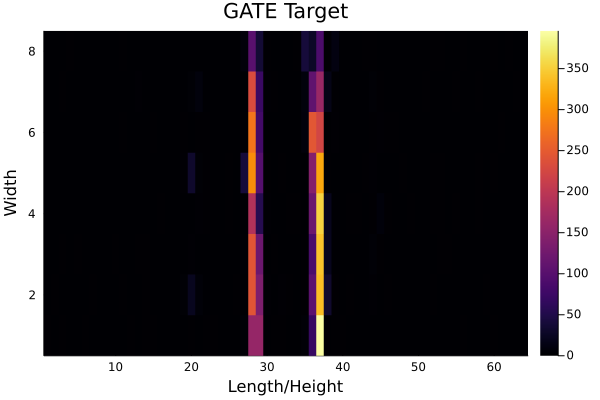

Validation R2: 0.924305016048766

	7

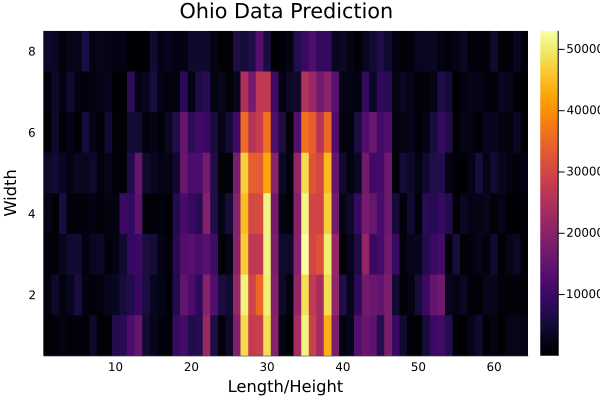

loss(trainingArray, targetArray) = 1074.807f0
loss(trainingArray, targetArray) = 1073.9117f0
loss(trainingArray, targetArray) = 1072.993f0
loss(trainingArray, targetArray) = 1072.0674f0
loss(trainingArray, targetArray) = 1071.1543f0
loss(trainingArray, targetArray) = 1070.2643f0
loss(trainingArray, targetArray) = 1069.3223f0
loss(trainingArray, targetArray) = 1068.4946f0
loss(trainingArray, targetArray) = 1067.6404f0
Training R2: 0.8887962983718837


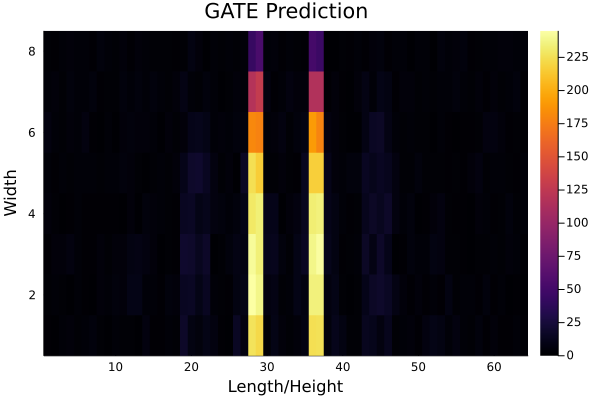

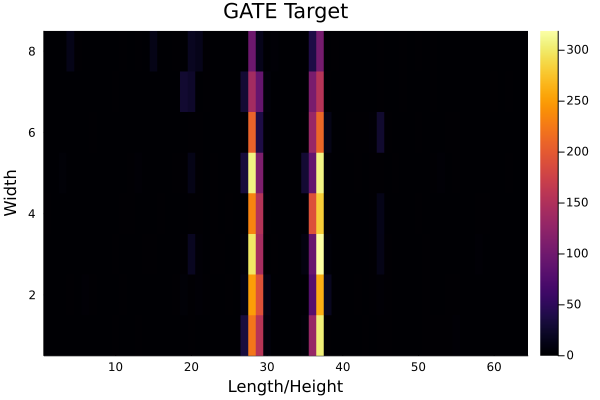

Validation R2: 0.927154017596798

	8

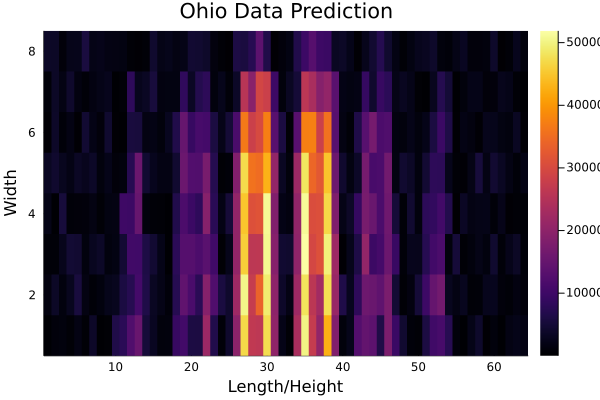

loss(trainingArray, targetArray) = 1067.3356f0
loss(trainingArray, targetArray) = 1066.4132f0
loss(trainingArray, targetArray) = 1065.5178f0
loss(trainingArray, targetArray) = 1064.6436f0
loss(trainingArray, targetArray) = 1063.8363f0
loss(trainingArray, targetArray) = 1062.945f0
loss(trainingArray, targetArray) = 1062.0098f0
loss(trainingArray, targetArray) = 1061.037f0
loss(trainingArray, targetArray) = 1060.12f0


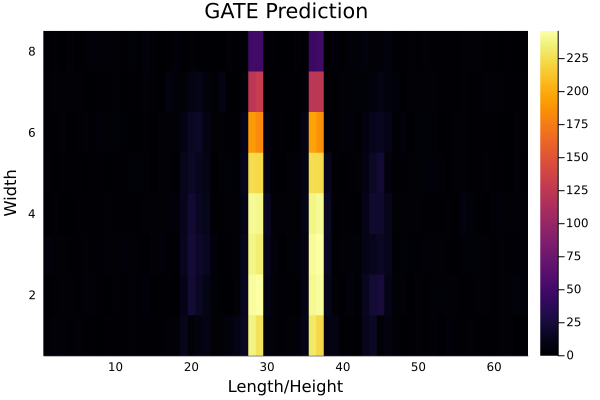

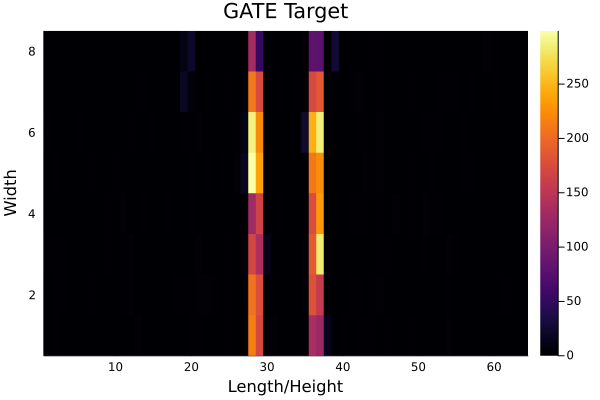

Training R2: 0.8982452030488851
Validation R2: 0.9318044316692569

	2

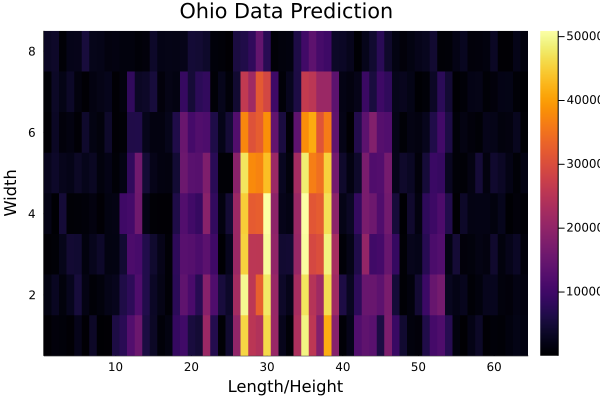

loss(trainingArray, targetArray) = 1059.6606f0
loss(trainingArray, targetArray) = 1058.6135f0
loss(trainingArray, targetArray) = 1057.6896f0
loss(trainingArray, targetArray) = 1056.5448f0
loss(trainingArray, targetArray) = 1055.3518f0
loss(trainingArray, targetArray) = 1054.1454f0
loss(trainingArray, targetArray) = 1053.1543f0
loss(trainingArray, targetArray) = 1052.3328f0
loss(trainingArray, targetArray) = 1051.3075f0
Training R2: 0.9189977799547184


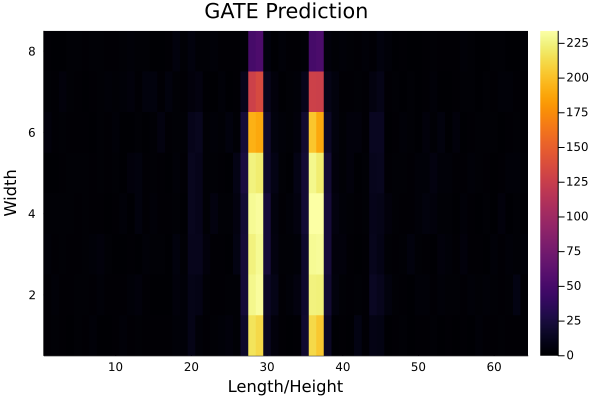

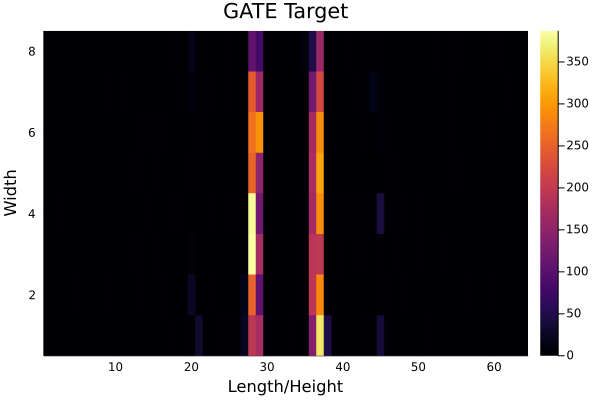

Validation R2: 0.9391366929736522

	4

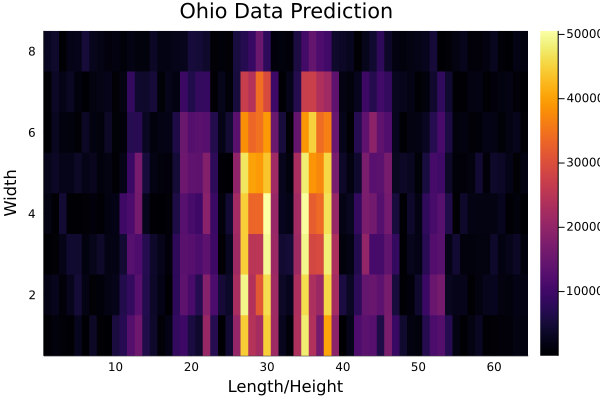

loss(trainingArray, targetArray) = 1050.6461f0
loss(trainingArray, targetArray) = 1049.7435f0
loss(trainingArray, targetArray) = 1048.9149f0
loss(trainingArray, targetArray) = 1048.0751f0
loss(trainingArray, targetArray) = 1047.2058f0
loss(trainingArray, targetArray) = 1046.2911f0
loss(trainingArray, targetArray) = 1045.3964f0
loss(trainingArray, targetArray) = 1044.6467f0
loss(trainingArray, targetArray) = 1043.7506f0
Training R2: 0.919465632723323


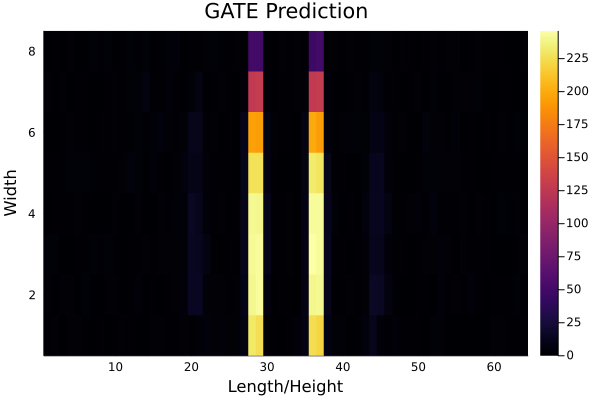

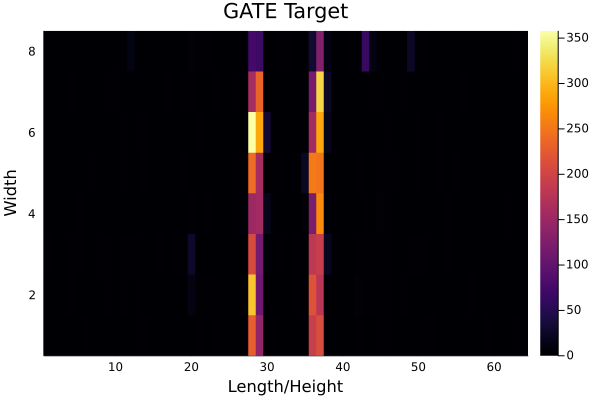

Validation R2: 0.9397997253558695

	5

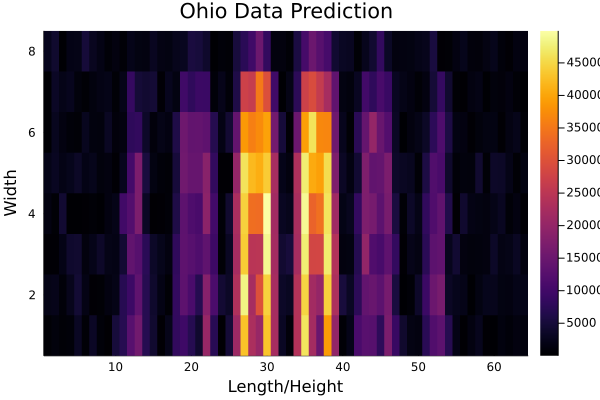

loss(trainingArray, targetArray) = 1043.4818f0
loss(trainingArray, targetArray) = 1042.7238f0
loss(trainingArray, targetArray) = 1041.9386f0
loss(trainingArray, targetArray) = 1041.1316f0
loss(trainingArray, targetArray) = 1040.3759f0
loss(trainingArray, targetArray) = 1039.476f0
loss(trainingArray, targetArray) = 1038.7137f0
loss(trainingArray, targetArray) = 1037.9464f0
loss(trainingArray, targetArray) = 1037.4728f0


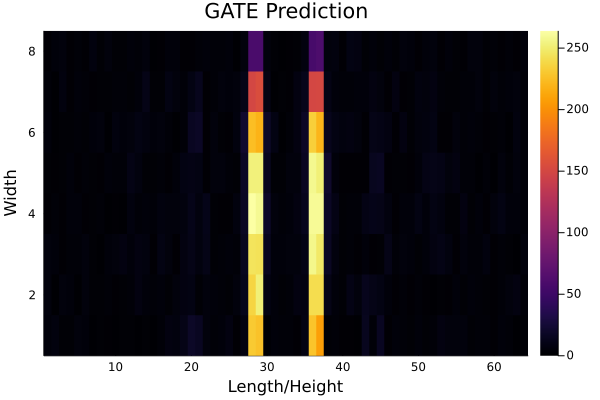

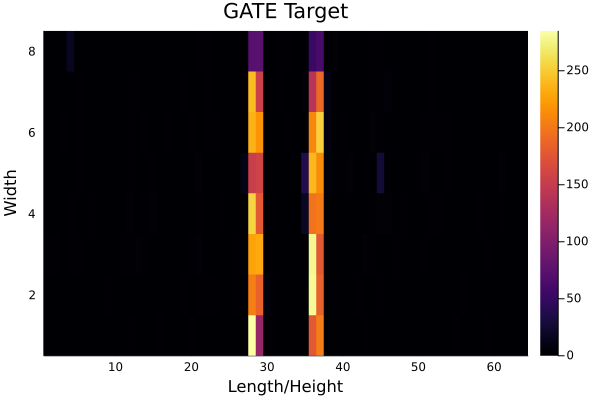

Training R2: 0.9174969998666122
Validation R2: 0.9418618762694257

	1

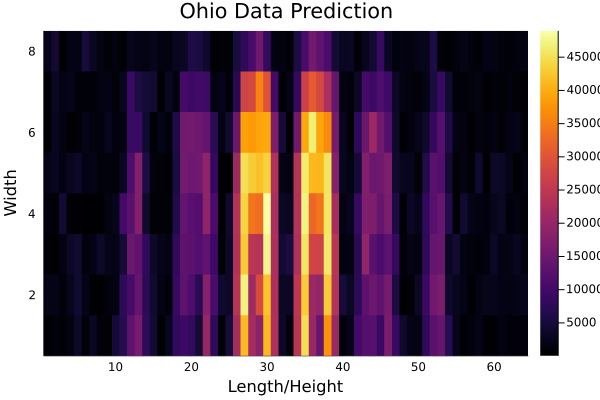

loss(trainingArray, targetArray) = 1037.0402f0
loss(trainingArray, targetArray) = 1036.5471f0
loss(trainingArray, targetArray) = 1035.5829f0
loss(trainingArray, targetArray) = 1034.4294f0
loss(trainingArray, targetArray) = 1033.6368f0
loss(trainingArray, targetArray) = 1032.7583f0
loss(trainingArray, targetArray) = 1032.1743f0
loss(trainingArray, targetArray) = 1031.7783f0
loss(trainingArray, targetArray) = 1030.7682f0


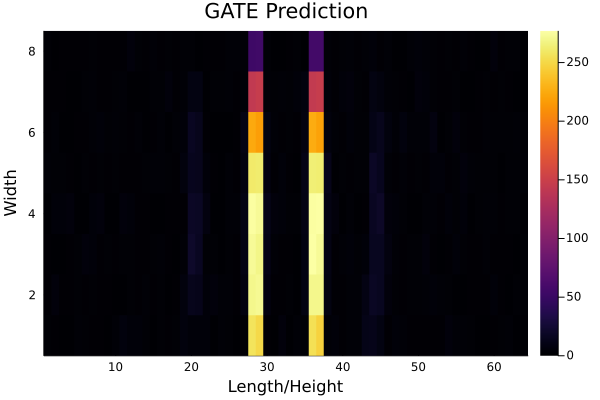

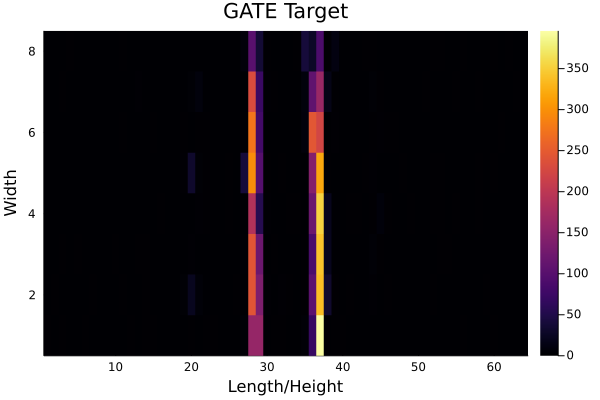

Training R2: 0.929917390573438
Validation R2: 0.9463438080916811

	7

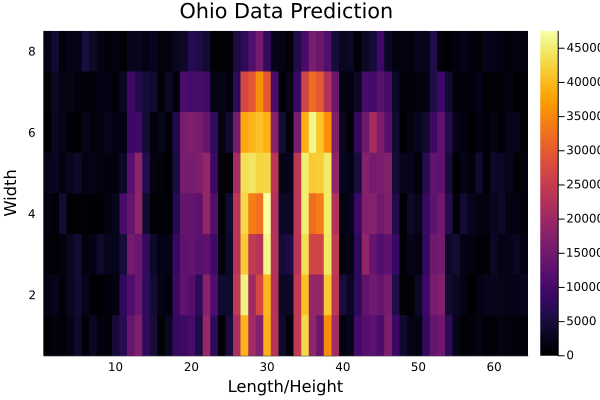

loss(trainingArray, targetArray) = 1031.2269f0
loss(trainingArray, targetArray) = 1029.8091f0
loss(trainingArray, targetArray) = 1029.2281f0
loss(trainingArray, targetArray) = 1028.1625f0
loss(trainingArray, targetArray) = 1027.6262f0
loss(trainingArray, targetArray) = 1026.7153f0
loss(trainingArray, targetArray) = 1025.8478f0
loss(trainingArray, targetArray) = 1025.0615f0
loss(trainingArray, targetArray) = 1025.9387f0


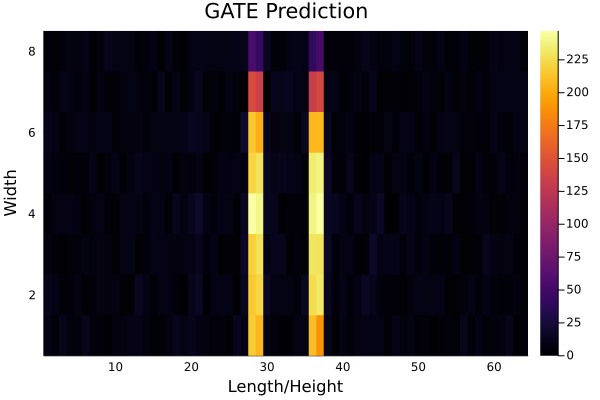

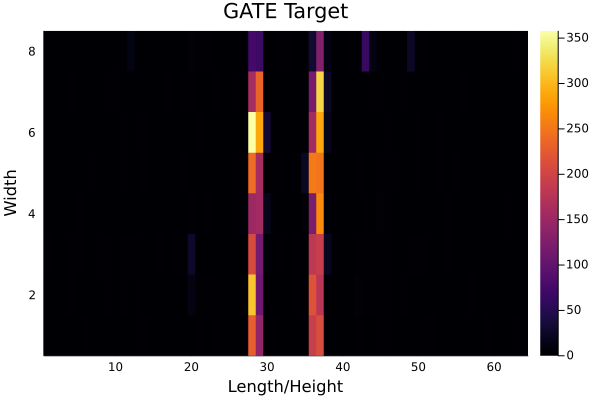

Training R2: 0.9329233555155977
Validation R2: 0.9462201770815305

	5

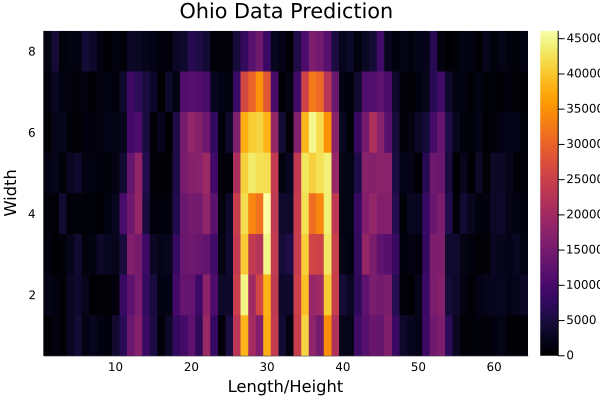

In [34]:
while i <= 20 && CVR2 < CurrentVR2
    CVR2 = CurrentVR2
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 5))
    CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
    print("Training R2: ", CurrentR2, '\n')
    CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
    print("Validation R2: ", CurrentVR2, '\n')
    print("\n\t")
    plotResults(m)
end

In [35]:
function writeOutput(m)
    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    readSize = size(readArray)[1]
    
    path = "/home/jupyter-nrmeskell/dosimeter/neural_nets/JuliaOutputs/OptimizedRuns"
    runNumber = lpad(size(readdir(path))[1], 3, "0")
    path = string(path, "/Run", runNumber, "R2-", lpad(Int(round(CurrentVR2, digits=3)*1000),3,"0"))
    mkdir(path)
    mkdir(string(path, "/fullSimulationOutputs"))
    mkdir(string(path, "/fullOhioOutputs"))
            
    for i = 1:size(validationTargetArray)[2]
        beamSize = filter(x->occursin(string("A000"), x), readdir(readPath))[div(i+2,3)][1:13]

        writedlm(string(path,"/fullSimulationOutputs/ValidationTarget",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(validationTargetArray[:,i], (8*8,8)), " ")
        writedlm(string(path,"/fullSimulationOutputs/ValidationOutput",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(m(validationArray)[:,i], (8*8,8)), " ")
    end


    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    for i = 1:size(inputArray)[4]
        writedlm(string(path,"/fullOhioOutputs/OhioOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(inputArray)[:,i], (8*8,8)))), " ")
    end
end

writeOutput (generic function with 1 method)

In [36]:
writeOutput(m)